# MRI Brain Tumor Classification

In [1]:
# Import Library

import kagglehub
import os
import cv2
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adamax, Nadam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


## 1. Memuat Dataset

In [2]:
# Download Dataset dari Kaggle
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path dataset:", path)

training_path = os.path.join(path, "Training")
testing_path = os.path.join(path, "Testing")

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path dataset: /kaggle/input/brain-tumor-mri-dataset


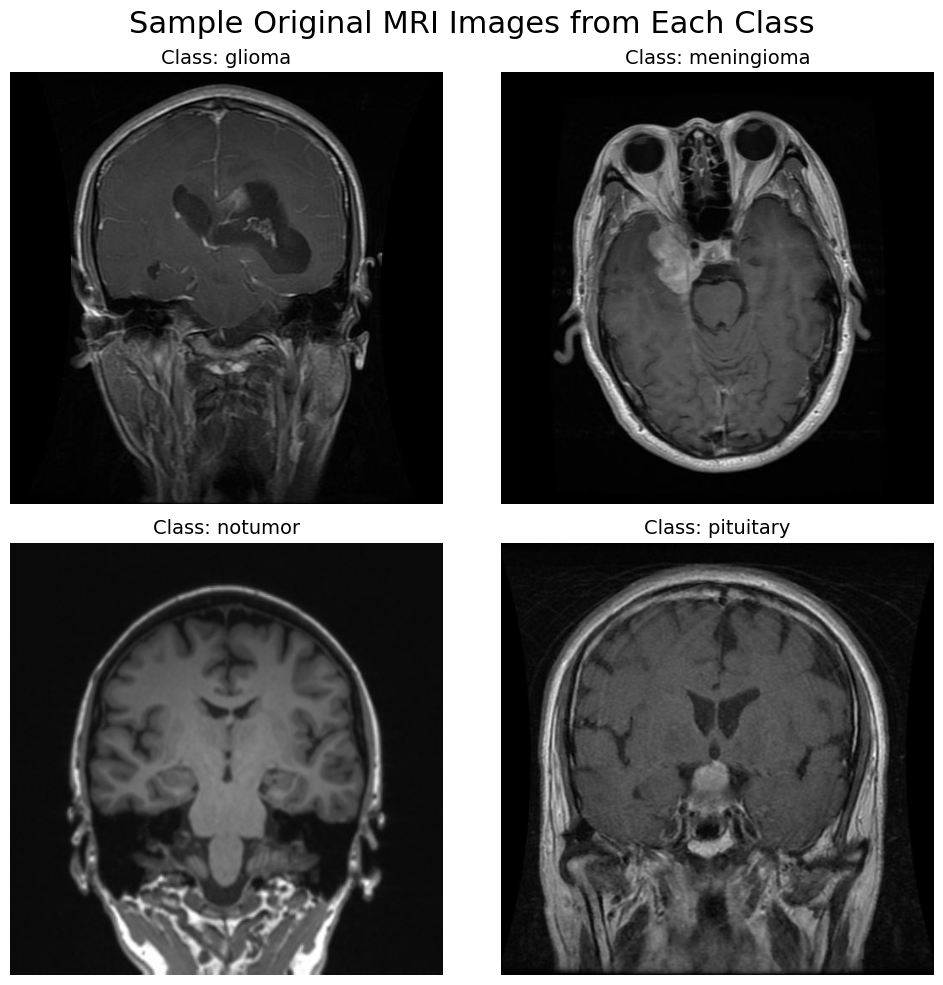

In [ ]:
# Visualisasi Contoh Gambar Mentah (Original) dari Dataset Training

plt.figure(figsize=(10, 10)) # Adjust figure size for 2x2 grid
plt.suptitle("Sample Original MRI Images from Each Class", fontsize=22) # Increased suptitle fontsize

# Get class names from training_path directories
class_names = sorted(os.listdir(training_path))

for i, class_label in enumerate(class_names):
    if i >= 4: # Only visualize up to 4 classes for a 2x2 grid
        break
    class_folder = os.path.join(training_path, class_label)
    # Get the first image file in the class folder
    image_files = sorted([f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png'))])
    if image_files:
        image_path = os.path.join(class_folder, image_files[4])
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for matplotlib

        plt.subplot(2, 2, i + 1) # Create a 2x2 grid
        plt.imshow(img_rgb)
        plt.title(f"Class: {class_label}", fontsize=14)
        plt.axis("off")

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

## 2. Preprocessing Gambar

In [4]:
# Preprocessing Gambar
def preprocess_image(image_path, target_size=(224, 224)):
    # Baca gambar dalam mode warna (BGR)
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        return None

    # Konversi ke grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(gray_blurred, 45, 255, cv2.THRESH_BINARY)

    # Temukan kontur terbesar (area otak)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    # Crop area otak
    cropped = img[y:y+h, x:x+w]

    # Resize ke ukuran target
    resized = cv2.resize(cropped, target_size)

    # Normalisasi (0-1)
    normalized = resized.astype("float32") / 255.0

    return normalized

## 3. Load Dataset & Preprocess Semua Gambar

In [5]:
# Load Dataset & Preprocess Semua Gambar
def load_dataset(base_path):
    data = []
    labels = []

    print(f"Memproses data dari: {base_path}")
    image_paths = list(paths.list_images(base_path))
    for image_path in image_paths:
        label = image_path.split(os.path.sep)[-2]  # nama folder = label
        img = preprocess_image(image_path)
        if img is not None:
            data.append(img)
            labels.append(label)

    return np.array(data), np.array(labels)


X_train, y_train = load_dataset(training_path)
X_test, y_test = load_dataset(testing_path)

print("Preprocessing selesai!")
print(f"Training data: {X_train.shape}, Testing data: {X_test.shape}")


Memproses data dari: /kaggle/input/brain-tumor-mri-dataset/Training
Memproses data dari: /kaggle/input/brain-tumor-mri-dataset/Testing
Preprocessing selesai!
Training data: (5712, 224, 224, 3), Testing data: (1311, 224, 224, 3)


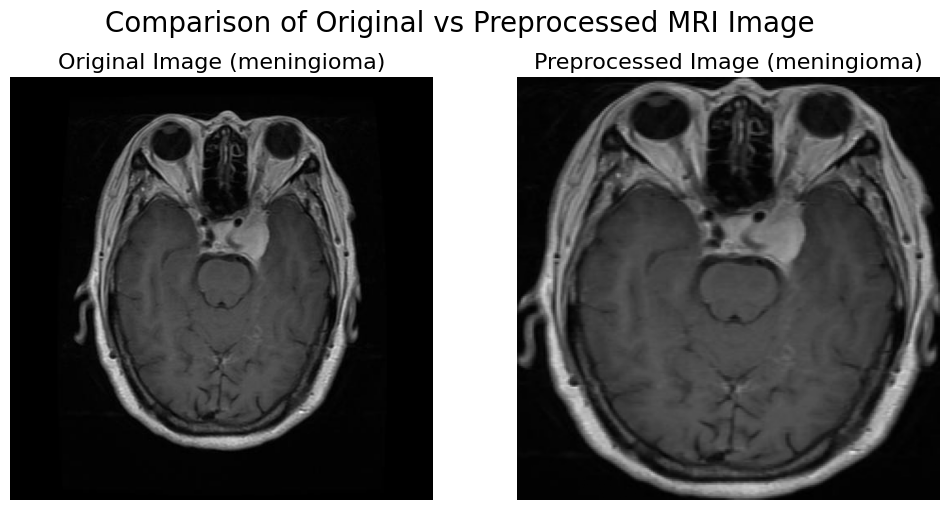

In [45]:
# Pilih satu contoh gambar untuk demonstrasi
example_image_path = os.path.join(training_path, 'meningioma', 'Tr-me_0013.jpg')
example_class = example_image_path.split(os.path.sep)[-2]

# Muat gambar original
img_original = cv2.imread(example_image_path)
img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

# Preprocess gambar
img_preprocessed = preprocess_image(example_image_path)

plt.figure(figsize=(12, 6))

# Plot gambar original
plt.subplot(1, 2, 1)
plt.imshow(img_original_rgb)
plt.title(f"Original Image ({example_class})", fontsize=16)
plt.axis("off")

# Plot gambar preprocessed
plt.subplot(1, 2, 2)
plt.imshow(img_preprocessed)
plt.title(f"Preprocessed Image ({example_class})", fontsize=16)
plt.axis("off")

# Judul keseluruhan untuk figure
plt.suptitle("Comparison of Original vs Preprocessed MRI Image", fontsize=20)

plt.subplots_adjust(top=0.92) # Adjust top margin to bring suptitle closer
plt.show()

## 4. Normalisasi Label (One-Hot Encoding)

In [7]:
# Normalisasi Label (One-Hot Encoding)
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

print("Kelas:", lb.classes_)


Kelas: ['glioma' 'meningioma' 'notumor' 'pituitary']


## 5. Augmentasi Data

In [8]:
# Augmentasi Data
train_datagen = ImageDataGenerator(
    rotation_range=10,           # Rotasi antara -10 sampai +10
    horizontal_flip=True,        # Flip horizontal
    fill_mode='nearest'          # Isi area kosong setelah rotasi
)

# Untuk validasi/test tidak perlu augmentasi
test_datagen = ImageDataGenerator()


## 6. Generator Data

In [9]:
# Generator Data
batch_size = 32

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=batch_size,
    shuffle=False
)


## 7. Contoh Hasil Augmentasi

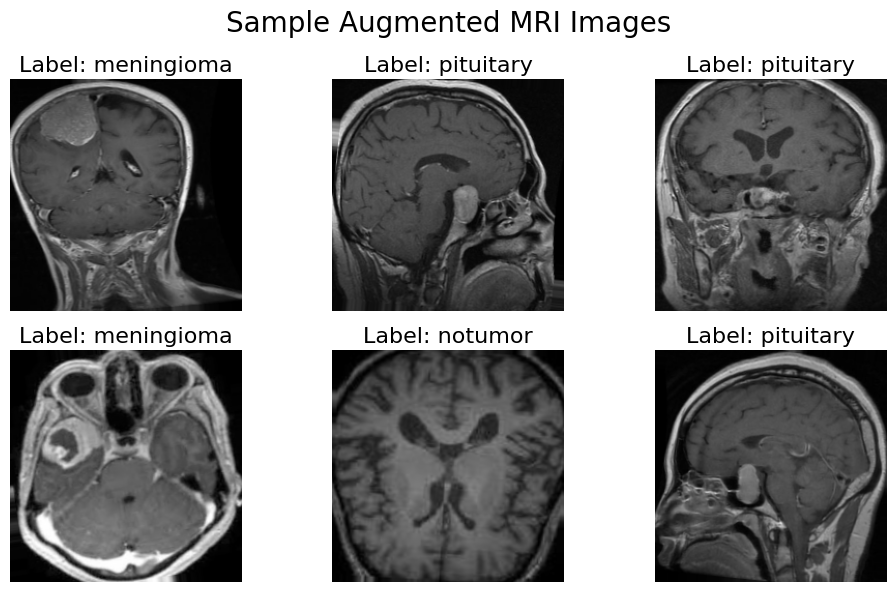

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Visualisasi beberapa contoh hasil augmentasi
images, labels = next(train_generator)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {lb.classes_[np.argmax(labels[i])]}", fontsize=16)
    plt.axis("off")

plt.suptitle("Sample Augmented MRI Images", fontsize=20)
plt.tight_layout()
plt.show()


## 8. Transfer Learning: ResNet50V2 Fine-Tuning

### 8.1. Load Base Model

In [11]:
# ============================================================
# FUNGSI UNTUK MEMBANGUN MODEL DENGAN OPTIMIZER
# ============================================================

def build_model_with_optimizer(opt):
    base_model = ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )

    # Freeze 80% layer pertama
    fine_tune_at = int(len(base_model.layers) * 0.8)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    # Tambahkan head untuk klasifikasi 4 kelas
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


### 8.2. Definisi Optimizer

In [12]:
# ============================================================
# DAFTAR OPTIMIZER
# ============================================================

optimizers = {
    "Adam": Adam(learning_rate=0.00005),
    "RMSprop": RMSprop(learning_rate=0.00005),
    "Nadam": Nadam(learning_rate=0.00005),
    "Adamax": Adamax(learning_rate=0.00005)
}

# Untuk menyimpan history, scores, dan model
histories_opt = {}
scores_opt = {}
models_opt = {}


### 8.3. Training dan Evaluasi Dasar

In [13]:
# ============================================================
# TRAINING & EVALUASI
# ============================================================

print("\n==============================")
print("  EKSPERIMEN 4 OPTIMIZER")
print("==============================\n")

for name, opt in optimizers.items():
    print(f"\n>>> Training dengan {name}")

    model_opt = build_model_with_optimizer(opt)

    history_opt = model_opt.fit(
        train_generator,
        validation_data=test_generator,
        epochs=15,
        callbacks=[
            # EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            ModelCheckpoint("best_resnet50v2_brain_tumor.keras", save_best_only=True)
        ],
        verbose=1
    )

    histories_opt[name] = history_opt
    models_opt[name] = model_opt

    # Evaluasi
    y_pred = model_opt.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    scores_opt[name] = {"acc": acc, "precision": precision, "recall": recall, "f1": f1}

    print(f"Hasil {name} -> Accuracy: {acc:.4f}, Precission: {precision:.4f}, Recall:{recall:.4f}, F1-score: {f1:.4f}")



  EKSPERIMEN 4 OPTIMIZER


>>> Training dengan Adam


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 116s 517ms/step - accuracy: 0.7008 - loss: 0.8658 - val_accuracy: 0.9382 - val_loss: 0.2864
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 376ms/step - accuracy: 0.9523 - loss: 0.2659 - val_accuracy: 0.9779 - val_loss: 0.1809
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 402ms/step - accuracy: 0.9763 - loss: 0.1828 - val_accuracy: 0.9855 - val_loss: 0.1517
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 66s 370ms/step - accuracy: 0.9854 - loss: 0.1518 - val_accuracy: 0.9832 - val_loss: 0.1634
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 410ms/step - accuracy: 0.9935 - loss: 0.1249 - val_accuracy: 0.9847 - val_loss: 0.1442
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 396ms/step - accuracy: 0.9924 - loss: 0.1188 - val_accuracy: 0.9863 - val_loss: 0.1343
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 375ms/step - accuracy: 0.9923 - loss: 0.1196 - val_accuracy: 0.9947 - val_loss: 0.1102
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 374ms/step - accuracy: 0.9969 - loss: 

### 8.4. Classification Report & Confusion Matrix



CLASSIFICATION REPORT - Adam
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       300
  meningioma       0.99      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



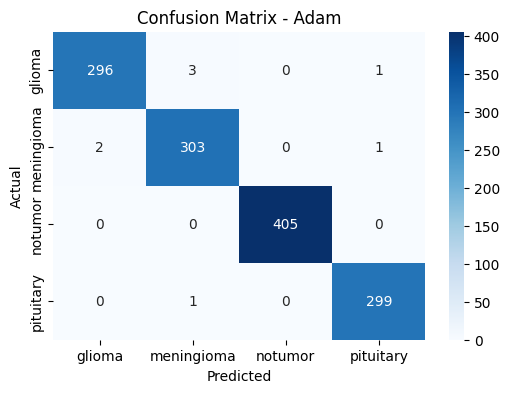


CLASSIFICATION REPORT - RMSprop
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       300
  meningioma       0.98      0.98      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



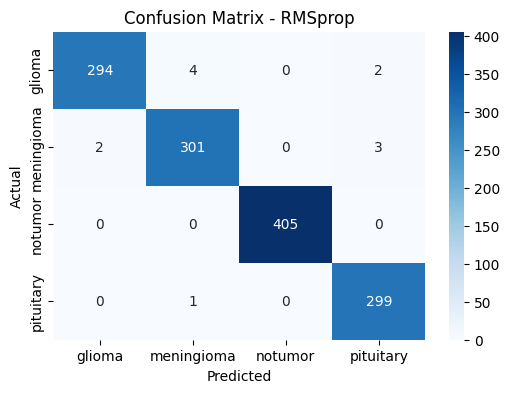


CLASSIFICATION REPORT - Nadam
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.97      0.98      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



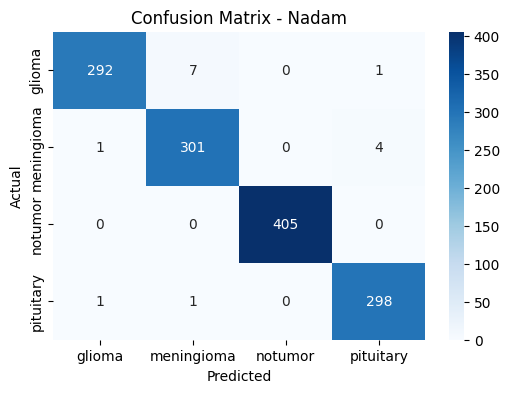


CLASSIFICATION REPORT - Adamax
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       300
  meningioma       0.96      0.98      0.97       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



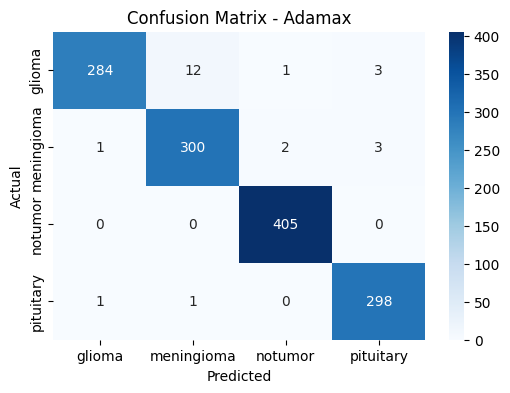

In [17]:
# ============================================================
# CLASSIFICATION REPORT & CONFUSION MATRIX
# ============================================================

class_labels = list(lb.classes_)

for name in models_opt:
    print(f"\n==============================")
    print(f"CLASSIFICATION REPORT - {name}")
    print("==============================")

    model_opt = models_opt[name]
    y_pred = model_opt.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### 8.5. Perbandingan Hasil Antar Optimizer

In [26]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Dictionary to store all metrics
all_metrics = {}

class_labels = list(lb.classes_)

for name, model in models_opt.items():
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

    # Extract weighted average metrics
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    all_metrics[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

df_all_metrics = pd.DataFrame(all_metrics).T
print("\n==========================================")
print("  RINGKASAN METRIK KINERJA PER OPTIMIZER")
print("==========================================\n")
display(df_all_metrics)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step

  RINGKASAN METRIK KINERJA PER OPTIMIZER



,Accuracy,Precision,Recall,F1-Score
Adam,0.993898,0.993903,0.993898,0.993896
RMSprop,0.990847,0.990876,0.990847,0.990841
Nadam,0.988558,0.988624,0.988558,0.988557
Adamax,0.981693,0.981917,0.981693,0.981636


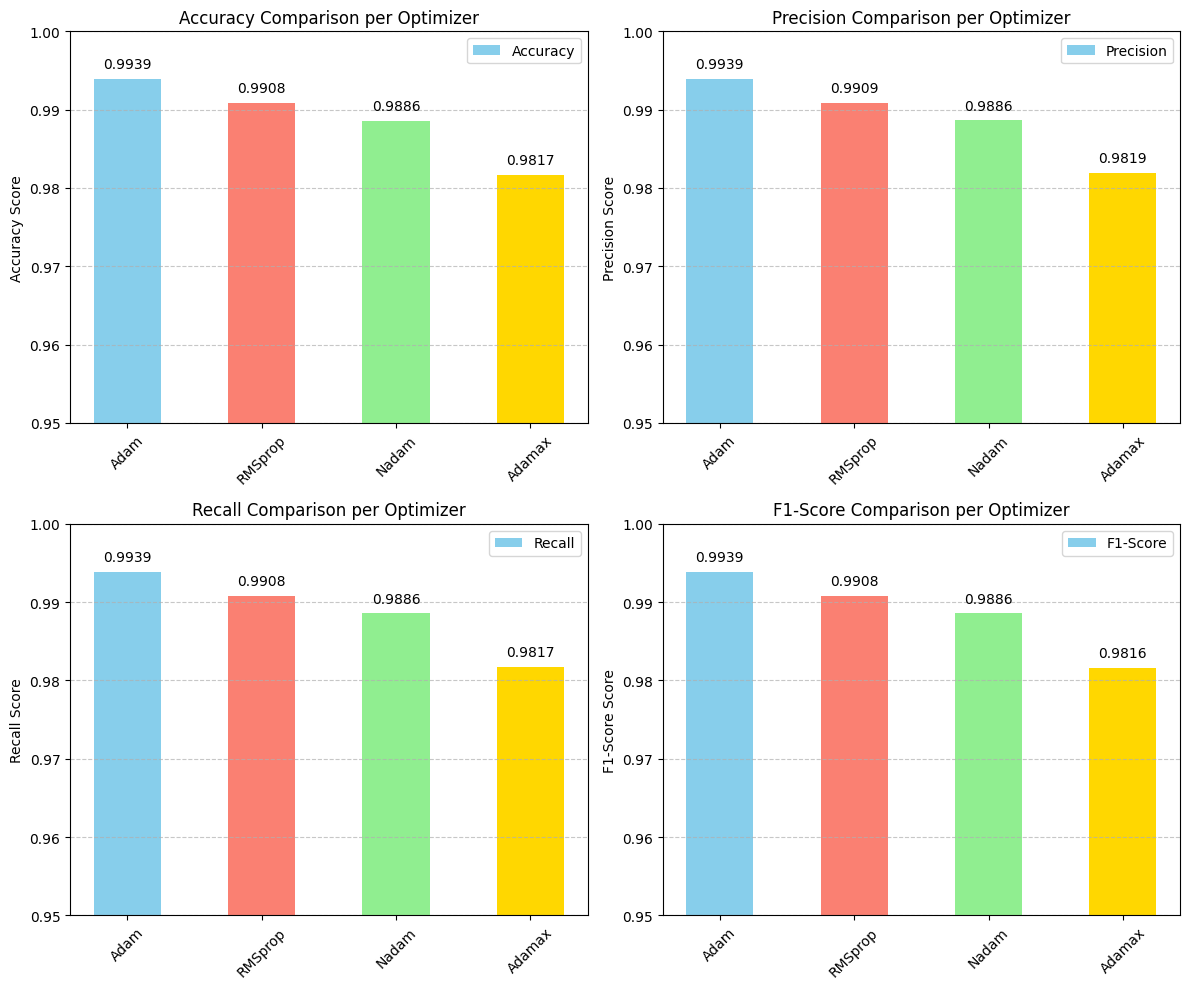

In [35]:
import matplotlib.pyplot as plt

# Mengatur ukuran figure
plt.figure(figsize=(12, 10))

# Menentukan metrik yang ingin dipetakan
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Daftar warna untuk setiap optimizer
colors = ['skyblue', 'salmon', 'lightgreen', 'gold']

# Menambahkan subplot untuk setiap metrik
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)  # Membuat grid 2x2

    # Mengambil jumlah optimizer untuk menyesuaikan warna
    num_bars = len(df_all_metrics.index)

    # Menggunakan warna berbeda per bar
    bar_colors = colors[:num_bars]  # ambil warna sesuai jumlah bar

    plt.bar(df_all_metrics.index, df_all_metrics[metric],
            width=0.5,
            color=bar_colors,
            label=metric)

    # Judul dan label
    plt.title(f"{metric} Comparison per Optimizer")
    plt.ylim(0.95, 1.0)
    plt.ylabel(f"{metric} Score")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Menambahkan angka di atas bar
    for j, v in enumerate(df_all_metrics[metric]):
        plt.text(j, v + 0.001, f"{v:.4f}", ha='center', va='bottom', fontsize=10)

    # Menambahkan legenda
    plt.legend()

# Layout rapi
plt.tight_layout()

plt.show()


### 8.6. Training vs Validation Accuracy dan Loss


  PERBANDINGAN TRAINING VS VALIDATION ACCURACY



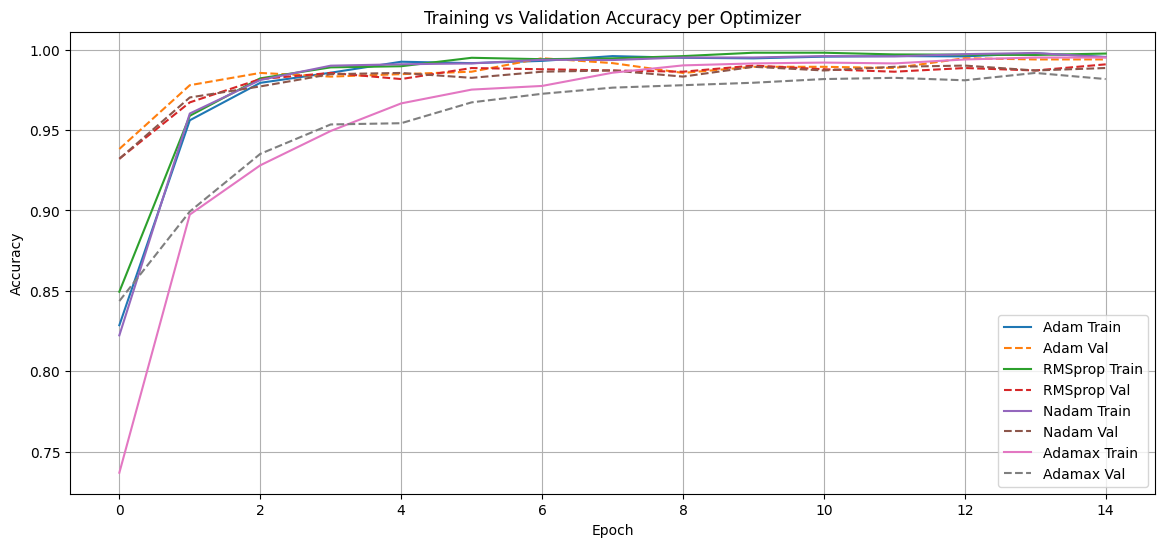


  PERBANDINGAN TRAINING VS VALIDATION LOSS



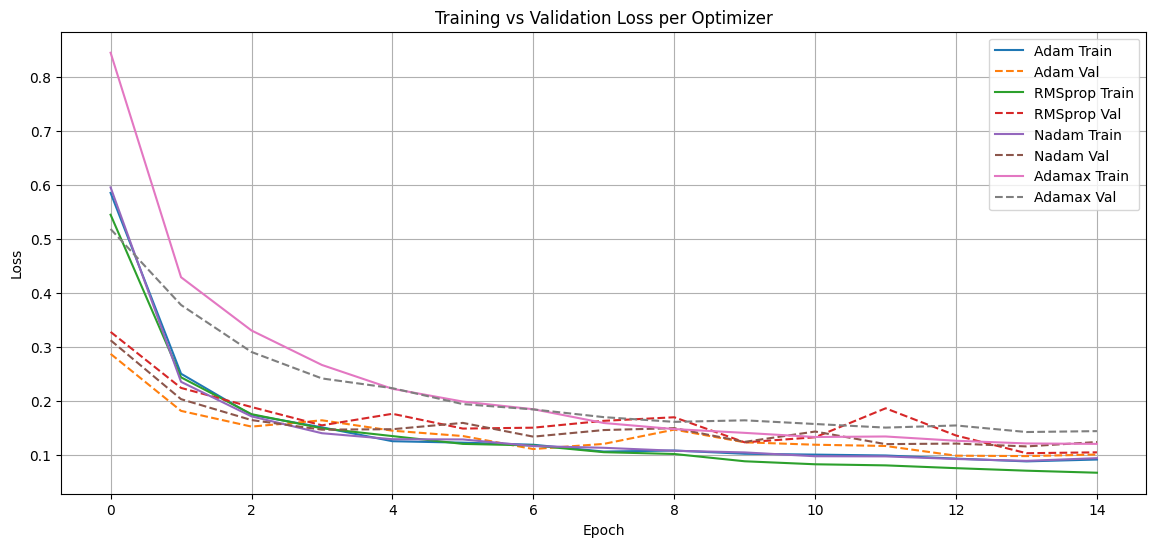

In [15]:
# ============================================================
# TRAINING VS VALIDATION ACCURACY & LOSS
# ============================================================

print("\n==============================")
print("  PERBANDINGAN TRAINING VS VALIDATION ACCURACY")
print("==============================\n")
plt.figure(figsize=(14,6))
for name in histories_opt:
    plt.plot(histories_opt[name].history['accuracy'], label=f"{name} Train")
    plt.plot(histories_opt[name].history['val_accuracy'], linestyle='--', label=f"{name} Val")
plt.title("Training vs Validation Accuracy per Optimizer")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print("\n==============================")
print("  PERBANDINGAN TRAINING VS VALIDATION LOSS")
print("==============================\n")
plt.figure(figsize=(14,6))
for name in histories_opt:
    plt.plot(histories_opt[name].history['loss'], label=f"{name} Train")
    plt.plot(histories_opt[name].history['val_loss'], linestyle='--', label=f"{name} Val")
plt.title("Training vs Validation Loss per Optimizer")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### 8.7. Plot Akurasi & Loss


OPTIMIZER - Adam

Training vs Validation Accuracy - Adam


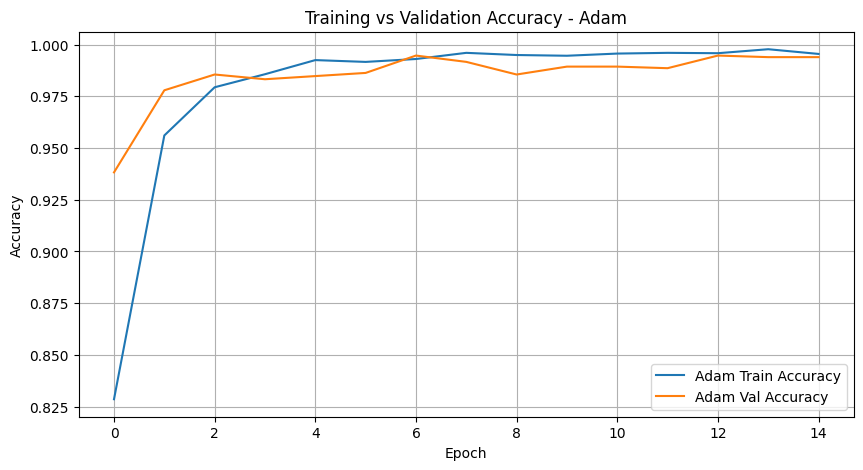


Training vs Validation Loss - Adam


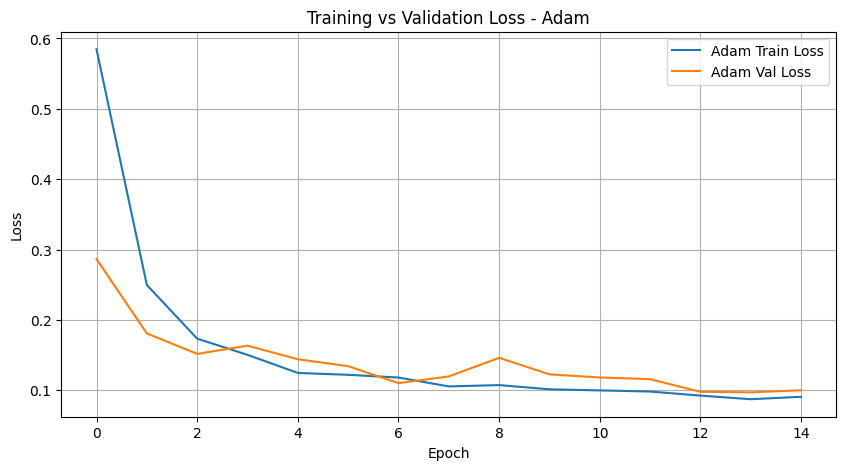


OPTIMIZER - RMSprop

Training vs Validation Accuracy - RMSprop


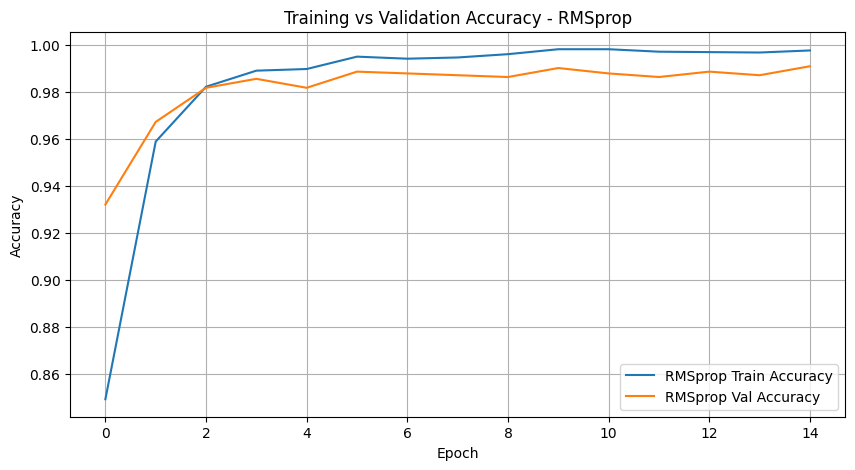


Training vs Validation Loss - RMSprop


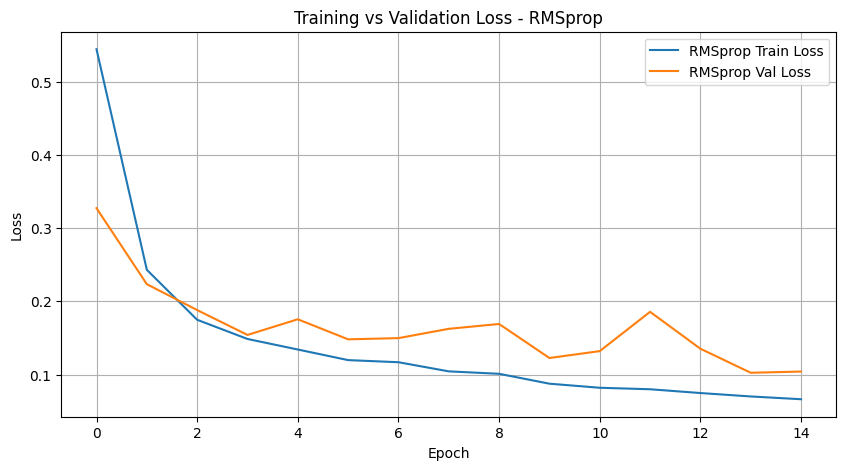


OPTIMIZER - Nadam

Training vs Validation Accuracy - Nadam


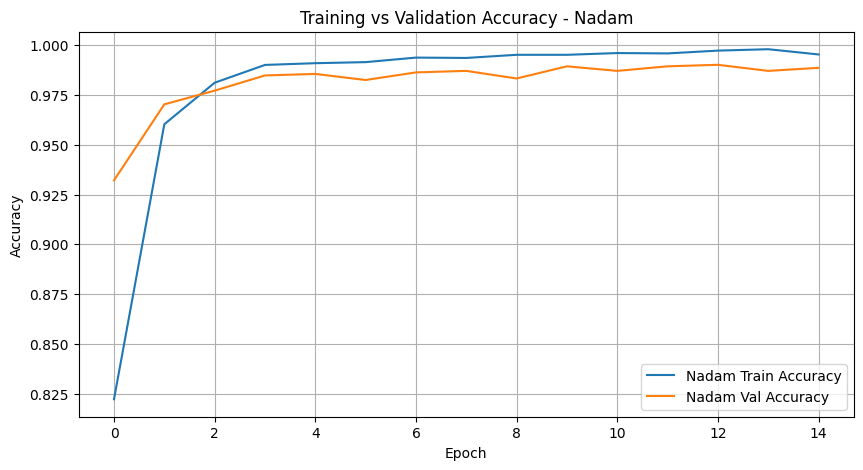


Training vs Validation Loss - Nadam


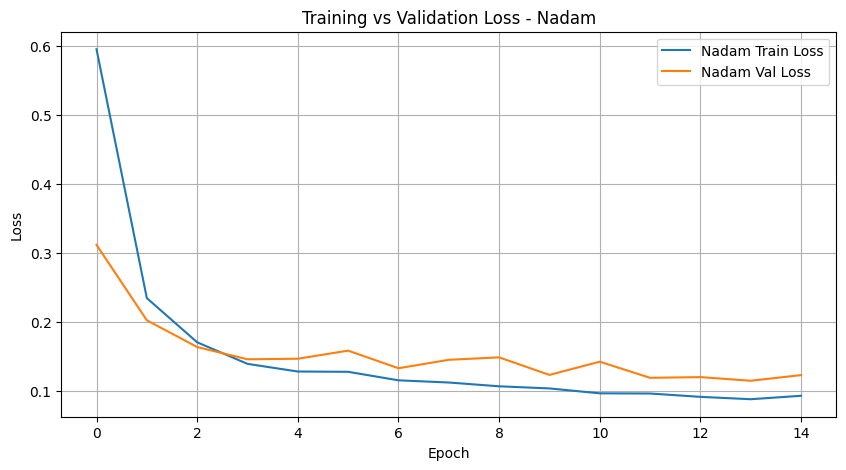


OPTIMIZER - Adamax

Training vs Validation Accuracy - Adamax


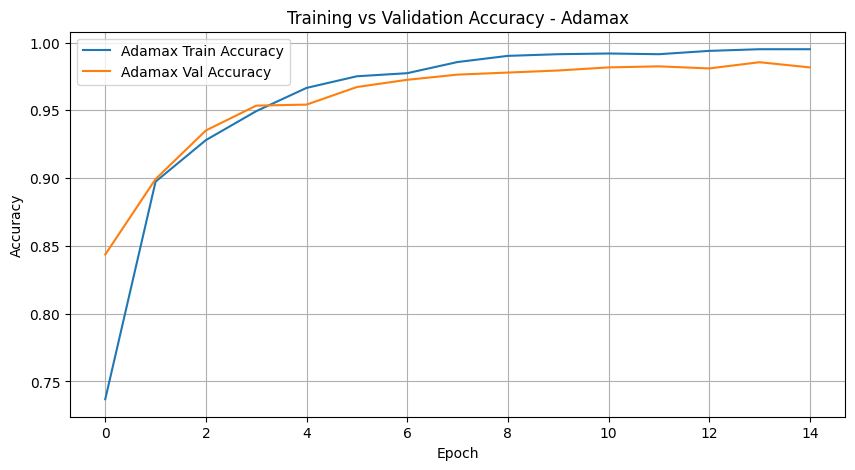


Training vs Validation Loss - Adamax


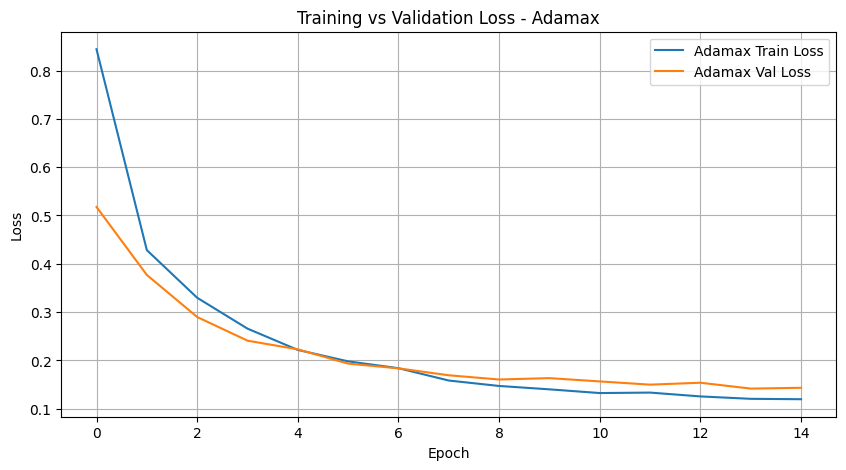

In [36]:
for name in histories_opt:
    print(f"\n==============================")
    print(f"OPTIMIZER - {name}")
    print("==============================")
    print(f"\nTraining vs Validation Accuracy - {name}")
    plt.figure(figsize=(10, 5))
    plt.plot(histories_opt[name].history['accuracy'], label=f'{name} Train Accuracy')
    plt.plot(histories_opt[name].history['val_accuracy'], label=f'{name} Val Accuracy')
    plt.title(f'Training vs Validation Accuracy - {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nTraining vs Validation Loss - {name}")
    plt.figure(figsize=(10, 5))
    plt.plot(histories_opt[name].history['loss'], label=f'{name} Train Loss')
    plt.plot(histories_opt[name].history['val_loss'], label=f'{name} Val Loss')
    plt.title(f'Training vs Validation Loss - {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

### 8.8. Ringkasan Akhir

In [21]:
from sklearn.metrics import classification_report
import pandas as pd

class_labels = list(lb.classes_)

print("\n==========================================")
print("  RINCIAN METRIK PER-KELAS UNTUK SETIAP OPTIMIZER")
print("==========================================\n")

for name, model in models_opt.items():
    print(f"\n--- Optimizer: {name} ---")
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Generate classification report as a dictionary
    report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

    # Convert the dictionary to a pandas DataFrame for better display
    df_report = pd.DataFrame(report).transpose()
    display(df_report)



  RINCIAN METRIK PER-KELAS UNTUK SETIAP OPTIMIZER


--- Optimizer: Adam ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


,precision,recall,f1-score,support
glioma,0.993289,0.986667,0.989967,300.000000
meningioma,0.986971,0.990196,0.988581,306.000000
notumor,1.000000,1.000000,1.000000,405.000000
pituitary,0.993355,0.996667,0.995008,300.000000
accuracy,0.993898,0.993898,0.993898,0.993898
macro avg,0.993404,0.993382,0.993389,1311.000000
weighted avg,0.993903,0.993898,0.993896,1311.000000



--- Optimizer: RMSprop ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


,precision,recall,f1-score,support
glioma,0.993243,0.980000,0.986577,300.000000
meningioma,0.983660,0.983660,0.983660,306.000000
notumor,1.000000,1.000000,1.000000,405.000000
pituitary,0.983553,0.996667,0.990066,300.000000
accuracy,0.990847,0.990847,0.990847,0.990847
macro avg,0.990114,0.990082,0.990076,1311.000000
weighted avg,0.990876,0.990847,0.990841,1311.000000



--- Optimizer: Nadam ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step


,precision,recall,f1-score,support
glioma,0.993197,0.973333,0.983165,300.000000
meningioma,0.974110,0.983660,0.978862,306.000000
notumor,1.000000,1.000000,1.000000,405.000000
pituitary,0.983498,0.993333,0.988391,300.000000
accuracy,0.988558,0.988558,0.988558,0.988558
macro avg,0.987701,0.987582,0.987605,1311.000000
weighted avg,0.988624,0.988558,0.988557,1311.000000



--- Optimizer: Adamax ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step


,precision,recall,f1-score,support
glioma,0.993007,0.946667,0.969283,300.000000
meningioma,0.958466,0.980392,0.969305,306.000000
notumor,0.992647,1.000000,0.996310,405.000000
pituitary,0.980263,0.993333,0.986755,300.000000
accuracy,0.981693,0.981693,0.981693,0.981693
macro avg,0.981096,0.980098,0.980413,1311.000000
weighted avg,0.981917,0.981693,0.981636,1311.000000



Accuracy


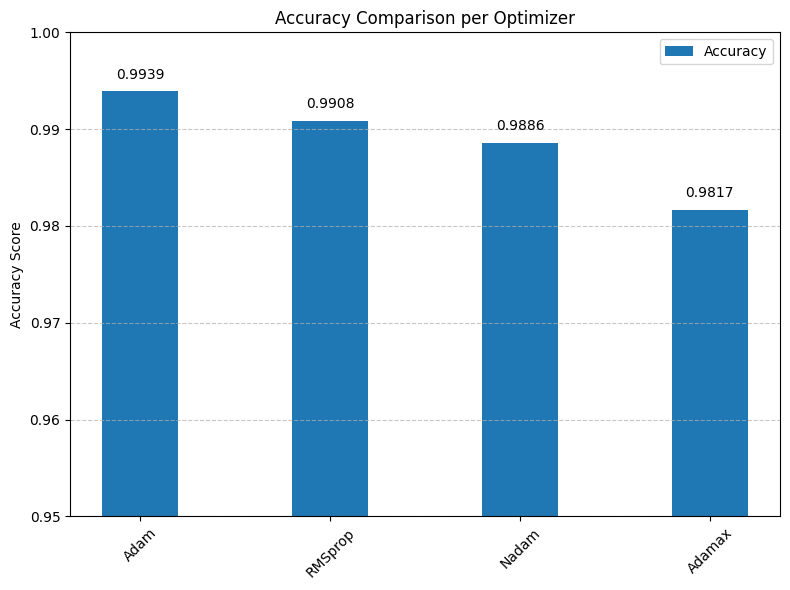


Precision


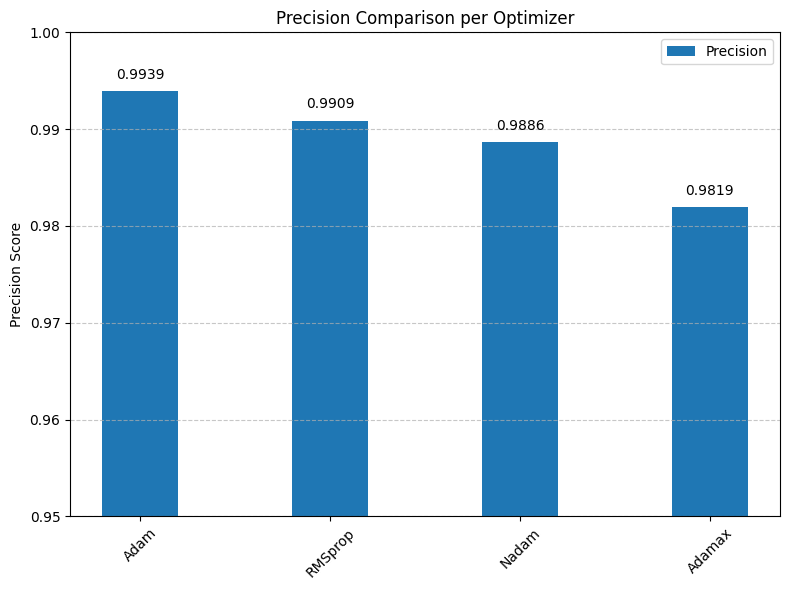


Recall


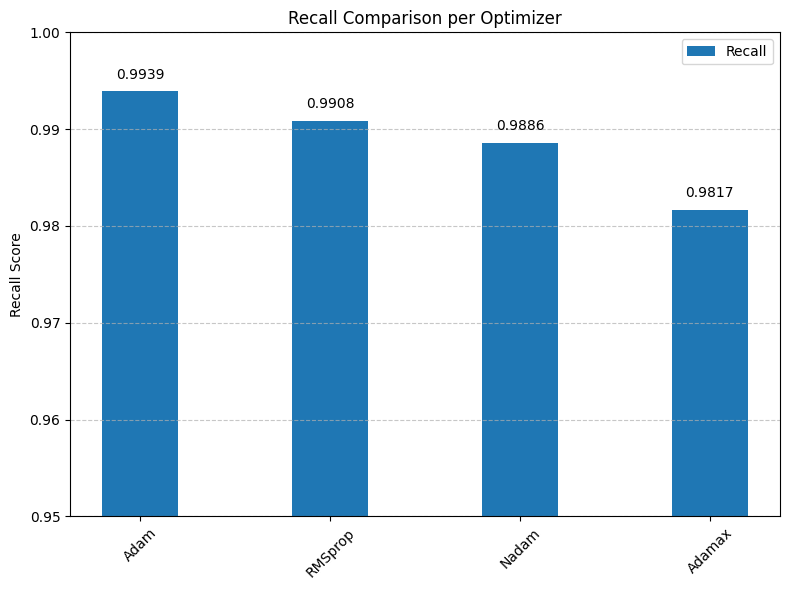


F1-Score


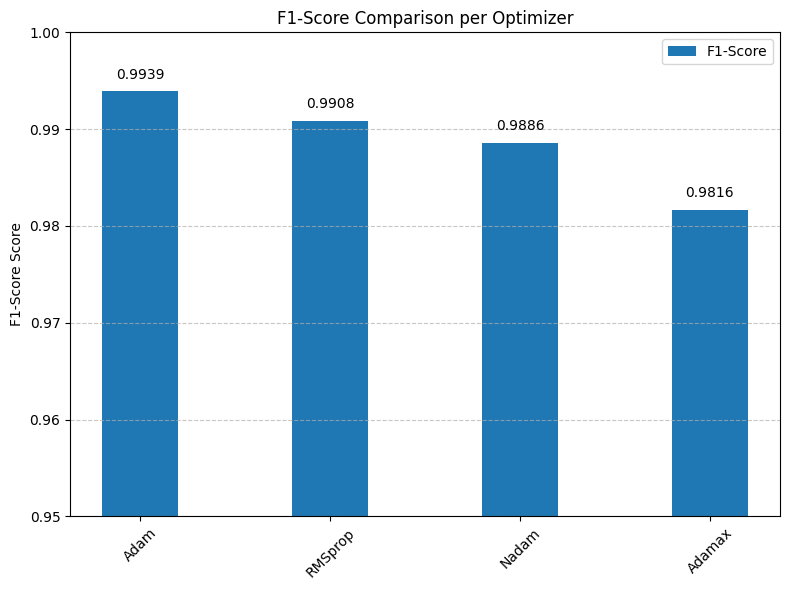

In [42]:
import matplotlib.pyplot as plt

# List metrik
metrics = df_all_metrics.columns

for metric in metrics:

    # Print block
    print("\n==============================")
    print(metric)
    print("==============================")

    # Membuat figure baru agar tidak berdempetan
    plt.figure(figsize=(8, 6))

    # Plot bar
    plt.bar(df_all_metrics.index, df_all_metrics[metric], width=0.4, label=metric)

    # Judul dan label
    plt.title(f"{metric} Comparison per Optimizer")
    plt.ylim(0.95, 1.0)
    plt.ylabel(f"{metric} Score")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Menambahkan angka di atas bar
    for i, v in enumerate(df_all_metrics[metric]):
        plt.text(i, v + 0.001, f"{v:.4f}", ha='center', va='bottom', fontsize=10)

    plt.legend()
    plt.tight_layout()
    plt.show()
